# MATH 420
## Jack Mirenzi - Camilo Velez
## Team HW 2

In [9]:
using Pkg
Pkg.activate("../p2")
Pkg.instantiate()
cd(dirname(@__DIR__))

  Activating project at `~/MATH420/p2`


In [11]:
using DelimitedFiles
using LinearAlgebra
using Plots
using LaTeXStrings
using Convex
using CSDP
using JLD
using CurveFit
using StatsBase

GHW1 = Dict{String,Any}("exactdist" => 0, "dist" => 0)
for name = ("dist", "exactdist")
    (R, num_vert_) = readdlm("Project_2/kn57Nodes1to57_" * name * ".txt", Float64, header=true)
    num_vert = parse(Float64, num_vert_[1])

    S = R .^ 2

    one_col = ones(57, 1)
    rho = 1 / (2num_vert) * one_col' * S * one_col
    rho = rho[1]

    v = ((S - rho * I(57)) * one_col) / num_vert
    function getGram(n::Real, S::Matrix, rho::Real)::Matrix
        r = 1 / 2n * (S - rho * I) * one_col * one_col' + 1 / 2n * one_col * one_col' * (S - rho * I) - 1 / 2 * S
        @assert issymmetric(r)
        return r
    end
    GHW1[name] = getGram(num_vert, S, rho)
end

In [13]:
# src code in hw2.jl
G_est = load("./G_est_dict")["G_est"]

Dict{Real, Dict{Any, Any}} with 2 entries:
  0.1 => Dict("Project_2/sparse/Sparse4kn57Nodes1to57_exactdist.txt"=>[3.79015e…
  1.0 => Dict("Project_2/sparse/Sparse4kn57Nodes1to57_exactdist.txt"=>[3.79015e…

In [16]:
files = readdir("Project_2/sparse")
files = joinpath.("Project_2/sparse", files)
noisy_files = last(files, 10)
noisy_files = vcat(noisy_files[2:end], noisy_files[1])

true_files = first(files, 10)
true_files = vcat(true_files[2:end], true_files[1]);


In [18]:
Error::Dict{Real,Vector} = Dict([0.1 => ones(10), 1 => ones(10)])
Error_Noisy::Dict{Real,Vector} = Dict([0.1 => ones(10), 1 => ones(10)])
for er1 = [0.1, 1]
    k = 1
    for f in true_files
        Error[er1][k] = norm(GHW1["exactdist"] - G_est[er1][f])
        k += 1
    end
    k = 1
    for f in noisy_files
        Error_Noisy[er1][k] = norm(GHW1["dist"] - G_est[er1][f])
        k += 1
    end
end

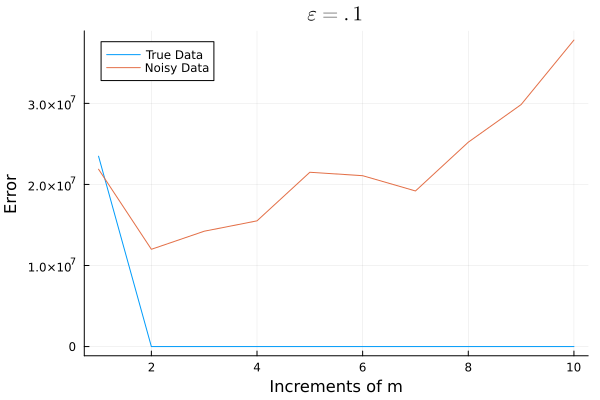

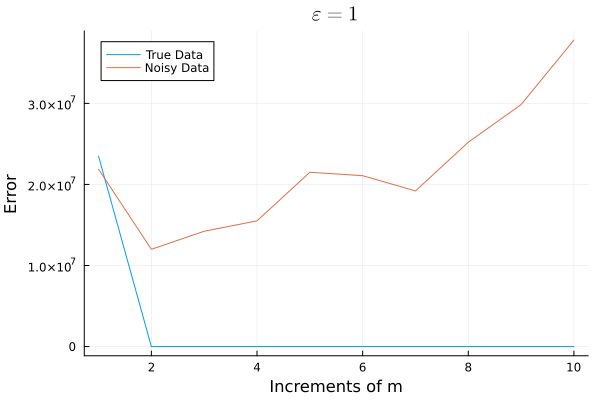

In [19]:
display(plot(range(1, 10, 10), [Error[0.1] Error_Noisy[0.1]], title=L"\epsilon=.1", label=["True Data" "Noisy Data"], xlabel="Increments of m", ylabel="Error"))
display(plot(range(1, 10, 10), [Error[1] Error_Noisy[1]], title=L"\epsilon=1", label=["True Data" "Noisy Data"], xlabel="Increments of m", ylabel="Error"))

In [54]:
@show mean(Error_Noisy[.1]) < mean(Error_Noisy[1])

mean(Error_Noisy[0.1]) < mean(Error_Noisy[1]) = true


true

L"$\text{For Error} = 0.1=\alpha e^{-\beta m} , α=2.8800649883625245e8, β=-0.015706912453869012$"

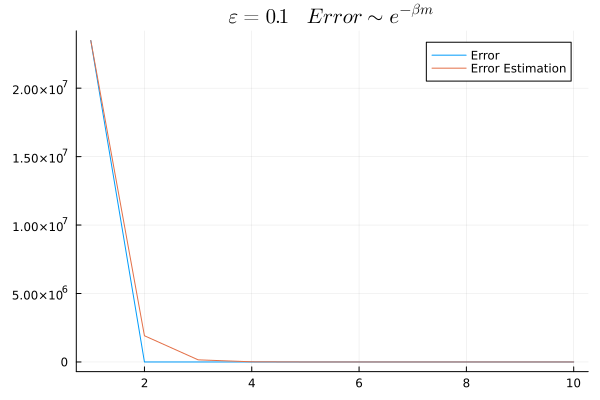

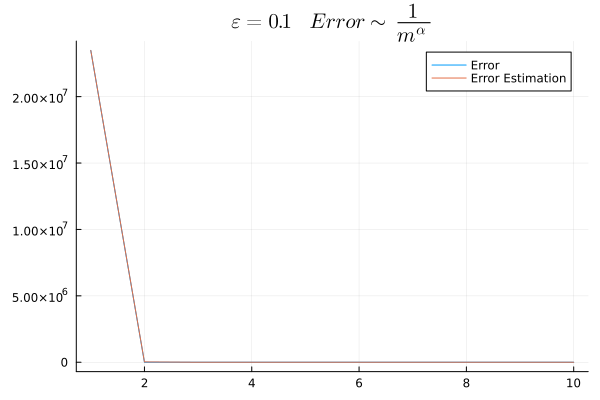

L"$\text{For Error} = 0.1=C \frac{1}{m^{\alpha}} , α=9.798295453828764, C=9.050444599650727e28$"

L"$\text{For Error} = 1.0=\alpha e^{-\beta m} , α=2.7319691991774124e8, β=-0.015376798072732296$"

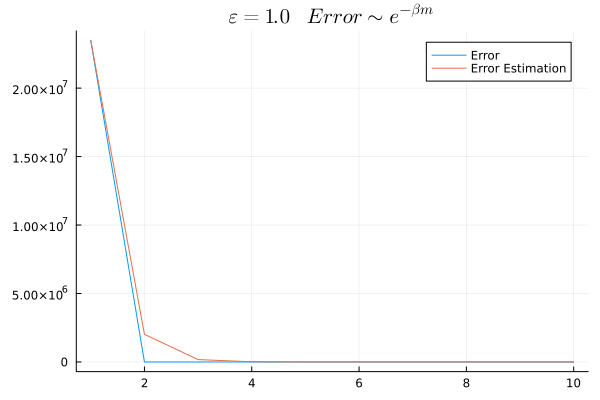

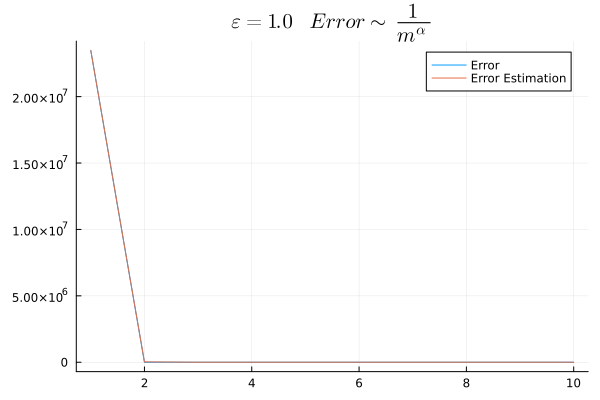

L"$\text{For Error} = 1.0=C \frac{1}{m^{\alpha}} , α=9.592363304564214, C=3.183827121020409e28$"

In [38]:
m(x) = (x / 10) * 57 * (56) / 2
loged_E = ones(10)
for k = 1:10
    loged_E[k] = log(m(k),Error[1][k])
end
for ep = [0.1 1]
    b_ = (log(Error[ep][end]) - log(Error[ep][1])) / (m(10) - m(1))
    a_ = Error[ep][1] / exp(b_ * m(1))
    pf2(x) = a_ * exp(b_ * x)
    display(L"\text{For Error} = %$(ep)=\alpha e^{-\beta m} , α=%$(a_), β=%$(b_)")
    display(plot(1:10, [(Error[ep]) (pf2.(m.(range(1, 10))))], title=L"\epsilon=%$(ep) \quad Error\sim e^{-\beta m}", label=["Error" "Error Estimation"]))

    c_ = exp((log(m(10),Error[ep][10])-log(m(1),Error[ep][1]))/(1/log(m(10))-1/log(m(1))))
    d_ = -1* log(m(1),Error[ep][1]/c_)
    pf3(x) = c_ * x^(-1 * d_)
    display(plot(1:10, [(Error[ep]) (pf3.(m.(1:10)))], title=L"\epsilon=%$(ep) \quad Error\sim \frac{1}{m^{\alpha}}", label=["Error" "Error Estimation"]))
    display(L"\text{For Error} = %$(ep)=C \frac{1}{m^{\alpha}} , α=%$(d_), C=%$(c_)")
end

It's easily noticeable that there's a sharp drop at increment 2 ($m$ goes from 161 to 313). This makes sense because the minimum value for $m\geq nd - \frac{d(d+1)}{2} = 165$ for 3D embedding.

In our SDP solving, changing the value of $\epsilon$ from 0.1 to 1 did not lead to significant differences. A lower value of $\epsilon$ did lead to a lower average error in the noisy data.

We suspect that there might be cases where a solver (CVX or CDSP in this case) can run into infeasible problems since we saw a significant decrease in the number of iterations that our solver ran -when working with noisy data- before declaring a solution "feasible" or "infeasible". We found it more important to prioritize arriving to a feasible solution than a precise one